## Bayesian Inference - Trajectory Estimation with Noisy Measurements
---

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimize

In [14]:
# unknown parameters which we have to estimate
theta_0 = {'loc': 200, 'scale': 50}
theta_1 = {'loc': 50, 'scale': 50}

def actual(t, height=theta_0['loc'], velo=theta_1['loc']):
  return height + velo*t + -9.81*t**2

In [15]:
# fixed time steps to plot trajectory
t_end = 12
t_time = pd.Series(np.arange(1, t_end+1))

# generate true line
Y = t_time.apply(actual)
Y.head()

0    240.19
1    260.76
2    261.71
3    243.04
4    204.75
dtype: float64

In [16]:
# noise in observations
W = {'loc': 0, 'scale': 50}

# number of observations
n_obs = 20
# timestamps of records
t_obs = np.random.randint(low=1, high=t_end, size=n_obs)


def normal(**kwargs):
  return np.random.normal(**kwargs)

def observed(t, height, velo, noise):
  return height + velo*t + -9.81*t**2 + noise

In [17]:
# generate noisy observation data
X = [observed(
    t=t, 
    height=normal(**theta_0), 
    velo=normal(**theta_1),  
    noise=normal(**W)) 
for t in t_obs]

X = pd.Series(data=X, index=t_obs)
X.head()

10   -829.030194
5     280.326697
11   -571.310568
9    -482.746980
10   -405.774767
dtype: float64

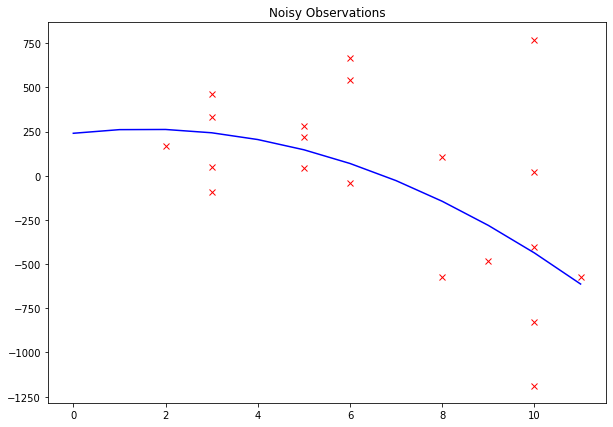

In [18]:
plt.figure(figsize=(10,7))
X.plot.line(color='r', lw=0, marker='x')
Y.plot.line(color='b')

plt.title('Noisy Observations')
plt.show()

In [19]:
# prior believes about parameters
prior_0 = 300
prior_1 = 80

def func(THETA, X=X):
  """Function represents the exponent of posterior distribution. 
  To find the maximum posterior density, the exponent has to be minimized."""

  theta_0, theta_1 = THETA

  y = (theta_0 - prior_0)**2 + \
      (theta_1 - prior_1)**2 + \
      np.sum((X.values - theta_0 - theta_1 * X.index + 9.81 * X.index**2)**2)
  return y

In [20]:
THETA = [prior_0, prior_1]

result = optimize.minimize(func, THETA)
theta_hat_0, theta_hat_1 = result.x

print('Theta_0: ', round(theta_hat_0, 2))
print('Theta_1: ', round(theta_hat_1, 2))

Theta_0:  235.79
Theta_1:  38.76


In [21]:
# Loss with prior theta
result.fun

3456794.3927772306

In [22]:
# Loss with updated theta
func(THETA)

6040148.7848268775

In [23]:
map_estimate = t_time.apply(
    actual, 
    height=theta_hat_0, 
    velo=theta_hat_1
)

In [24]:
prior_estimate = t_time.apply(
    actual, 
    height=prior_0, 
    velo=prior_1
)

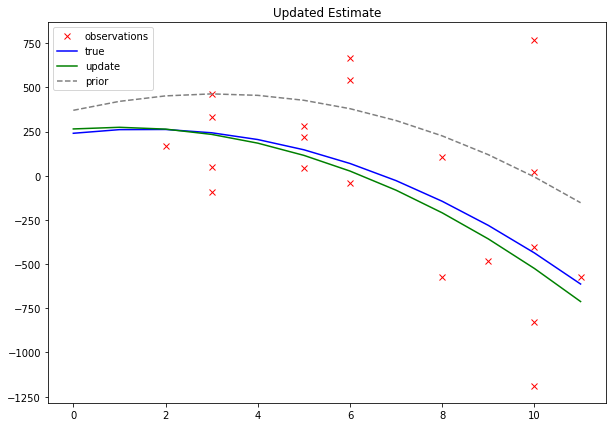

In [25]:
plt.figure(figsize=(10,7))
X.plot.line(color='r', lw=0, marker='x', label='observations')
Y.plot.line(color='b', label='true')

map_estimate.plot.line(color='g', label='update')
prior_estimate.plot.line(color='grey', ls='--', label='prior')

plt.legend()
plt.title('Updated Estimate')
plt.show()